In [1]:
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.widgets as sw
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from pathlib import Path
import spikeinterface_gui as sigui
import warnings
warnings.simplefilter("ignore")
%matplotlib widget
print(f"SpikeInterface version: {si.__version__}")

SpikeInterface version: 0.98.0


In [2]:
# file paths
base_folder = Path('.')
data_folder = Path("C:/Users/rodri/Documents/Bonsai-RN/Bonsai_DataRN/2023_3_21/")
#Pasted directly from explorer "C:\Users\rodri\Documents\Bonsai-RN\Bonsai_DataRN\2023_3_21\"
recording_file = data_folder / "RawEphysData_64Ch_F-Probe10.bin"
# parameters to load the bin/dat format
num_channels = 64 #must know apriori; modify in probe below accordingly.
sampling_frequency = 30000
gain_to_uV = 0.195
offset_to_uV = 0
t_starts = 0
dtype = "float32"
time_axis = 0

In [3]:
recording = si.read_binary(recording_file, num_chan=num_channels,sampling_frequency=sampling_frequency,
                           dtype=dtype, gain_to_uV=gain_to_uV, offset_to_uV=offset_to_uV, 
                           time_axis=time_axis, is_filtered=False)

channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_segments = recording.get_num_segments()
trace_snippet = recording.get_traces(start_frame=int(fs*0), end_frame=int(fs*60))
trace_total_duration = recording.get_total_duration()
trace_total_samples = recording.get_total_samples()

print(f'Channel ids: {channel_ids}')
print(f'Sampling frequency: {fs}')
print(f'Number of channels: {num_chan}')
print(f"Number of segments: {num_segments}")
print('Trace Shape:', trace_snippet.shape)
print('Trace Total Duration:', trace_total_duration)
print('Trace Total Samples:', trace_total_samples)
recording_1min_slice = recording.frame_slice(start_frame=int(0), end_frame=int(fs*60)) #in samples=30000samples*60sec (fs*60)
#se.recording_extractor_full_dict

Channel ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Sampling frequency: 30000
Number of channels: 64
Number of segments: 1
Trace Shape: (1800000, 64)
Trace Total Duration: 14356.04
Trace Total Samples: 430681200


In [48]:
import probeinterface as pi
from probeinterface import Probe, ProbeGroup
from probeinterface import generate_linear_probe, get_probe, generate_multi_shank
from probeinterface import combine_probes
from probeinterface import generate_multi_columns_probe
from probeinterface.plotting import plot_probe, plot_probe_group 
from probeinterface import generate_dummy_probe
from probeinterface import write_probeinterface, read_probeinterface
from probeinterface import write_prb, read_prb
print(f"ProbeInterface version: {pi.__version__}")

ProbeInterface version: 0.2.17


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43' '44'
 '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57' '58'
 '59' '60' '61' '62' '63' '64']
['4' '5' '4' '4' '4' '5' '5' '5' '5' '4' '4' '5' '5' '5' '5' '5' '4' '3'
 '4' '3' '4' '3' '3' '4' '3' '3' '3' '3' '3' '3' '4' '3' '2' '1' '2' '2'
 '2' '2' '2' '2' '1' '2' '2' '1' '2' '1' '2' '1' '0' '0' '0' '1' '0' '1'
 '1' '0' '1' '1' '0' '1' '0' '0' '0' '0']
2
um
{'name': 'ASSY-158-F', 'manufacturer': 'cambridgeneurotech', 'first_index': 1}
[[ 816.5   75. ]
 [1000.   120. ]
 [ 800.     0. ]
 [ 816.5  135. ]
 [ 816.5   15. ]
 [1016.5   45. ]
 [1016.5  105. ]
 [1016.5   75. ]
 [1016

,contact_ids,shank_ids,device_channel_indices
0,1,4,0
1,2,5,1
2,3,4,2
3,4,4,3
4,5,4,4
...,...,...,...
59,60,1,59
60,61,0,60
61,62,0,61
62,63,0,62


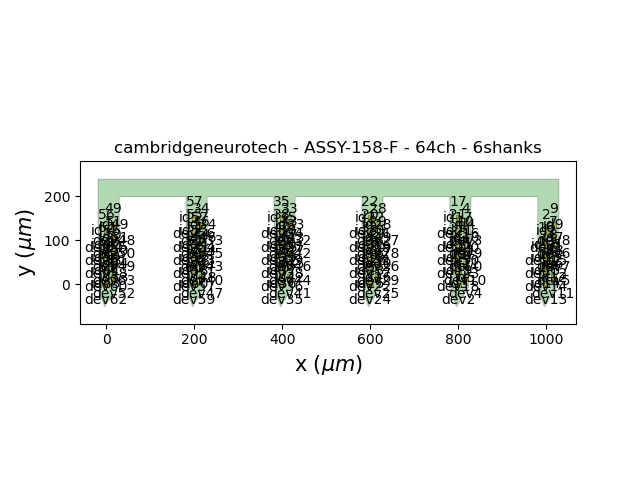

In [56]:
#download probe
probeF64 = pi.get_probe(manufacturer='cambridgeneurotech',
                     probe_name= 'ASSY-158-F')#probe object from library comes with contact and shank info
#add wiring to probe using wither a) or b)
#a)
#probeF64.wiring_to_device('ASSY-156>RHD2164')# fits 64Ch cambridge probes. Not acccurate?
#b) - With mapping by using the 2 lines below
device_channel_indices_mapped = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,
               61,62,63] #based on how recording was saved in Bonsai (mapped channels saved).print(probeF64)
probeF64.set_device_channel_indices(device_channel_indices_mapped)
#device_channel_indices_raw = [24,23,25,22,26,21,27,20,28,19,29,18,30,17,31,16,0,15,1,14,2,13,3,12,4,11,5,10,6,9,7,8,
#                             56,55,57,54,58,53,59,52,60,51,61,50,62,49,63,48,32,47,33,46,34,45,35,44,36,43,37,42,38,41,39,40] #raw rec.
print(probeF64.device_channel_indices)
print(probeF64.contact_ids)
print(probeF64.shank_ids)
print(probeF64.ndim)
print(probeF64.si_units)
print(probeF64.annotations) 
print(probeF64.contact_positions)
print(probeF64.contact_shapes)
print(probeF64.contact_shape_params)      

plot_probe(probeF64, with_channel_index=True, with_device_index=True, with_contact_id=True)
probeF64.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

In [63]:
recording_prb = recording.set_probe(probeF64, group_mode="by_shank")
recordings_by_group = recording_prb.split_by("group") #by group of channels (in shanks=shank_ids?)
recording_shank1 = recordings_by_group[0]
recording_shank1.get_num_channels()
recording_shank1_ft = spre.bandpass_filter(recording_shank1, freq_min=400, freq_max=5000)
recording_shank1_cmr = spre.common_reference(recording_shank1_ft, reference='global', operator='median')
probeF10 = recording_shank1_cmr.get_probe()
print(recording_shank1_cmr)
print(recording_shank1_cmr.get_probe())
print(recording_shank1_cmr.get_channel_ids())
print(recording_shank1_cmr.get_channel_groups())
print(recording_shank1_cmr.get_channel_locations())

CommonReferenceRecording: 10 channels - 30.0kHz - 1 segments - 430,681,200 samples 
                          14,356.04s (3.99 hours) - float32 dtype - 16.04 GiB
Probe - 10ch - 1shanks
[48 49 50 52 55 58 60 61 62 63]
[0 0 0 0 0 0 0 0 0 0]
[[ 16.5 135. ]
 [ 16.5  75. ]
 [ 16.5 105. ]
 [ 16.5  15. ]
 [  0.  120. ]
 [  0.   60. ]
 [  0.   30. ]
 [  0.   90. ]
 [  0.    0. ]
 [ 16.5  45. ]]


In [47]:
probeinterface.io.read_probeinterface('ASSY-158-F_CambridgeNeuro.json')

#probeNew = read_prb('Probe1shank32chRod.prb')

print(probeNew)
plot_probe(probeNew)

NameError: name 'probeinterface' is not defined

In [19]:
recording_to_sort = recording_shank1_cmr.set_probe(probeNew)

AssertionError: must give Probe

In [ ]:
#Shank 2 of F64 probe, 11 channels
recording_shank2 = recordings_by_group[1]
recording_shank2.get_num_channels()
recording_shank2_ft = spre.bandpass_filter(recording_shank2, freq_min=400, freq_max=5000)
recording_shank2_cmr = spre.common_reference(recording_shank2_ft, reference='global', operator='median')
probeF11 = recording_shank2_cmr.get_probe()
print(recording_shank2_cmr)
print(recording_shank2_cmr.get_probe())
print(recording_shank2_cmr.get_channel_ids())
print(recording_shank2_cmr.get_channel_groups())
print(recording_shank2_cmr.get_channel_locations())


import csv
file = 'TTL0_0.csv'
with open(file, newline='') as f:
    reader = csv.reader(f)
    your_list = list(reader)

print(your_list)

In [ ]:
from pprint import pprint
#default_TDC_params = ss.get_default_sorter_params('tridesclous')
default_SC2_params = ss.get_default_sorter_params('spykingcircus2')
# Parameters can be changed by single arguments: 
#default_SC2_params['detect_threshold'] = 6
pprint(default_SC2_params)

In [64]:
recording_shank1_cmr.set_probe(probeF10)

CommonReferenceRecording: 10 channels - 30.0kHz - 1 segments - 430,681,200 samples 
                          14,356.04s (3.99 hours) - float32 dtype - 16.04 GiB

In [65]:
#run spike sorting on entire recording of shank1.
#set_dummy_probe_from_locations(probeF21)
recording_sub = recording_shank1_cmr.frame_slice(start_frame=0*fs, end_frame=30*fs)
sorting_SC2_s1 = ss.run_sorter('spykingcircus2', recording_sub, 
                            output_folder=base_folder / 'results_SC2_7-20_s1', 
                            verbose=True)
pprint(sorting_SC2_s1)

detect peaks using locally_exclusive with n_jobs = 1 and chunk_size = 30000


detect peaks using locally_exclusive:   0%|          | 0/30 [00:00<?, ?it/s]

We found 4940 peaks in total
We kept 4940 peaks for clustering
features_from_peaks with n_jobs = 1 and chunk_size = 30000


features_from_peaks:   0%|          | 0/30 [00:00<?, ?it/s]

We found 10 raw clusters, starting to clean with matching...
Error running spykingcircus2


SpikeSortingError: Spike sorting error trace:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\SI-env\lib\site-packages\spikeinterface\sorters\basesorter.py", line 234, in run_from_folder
    SorterClass._run_from_folder(sorter_output_folder, sorter_params, verbose)
  File "c:\ProgramData\Anaconda3\envs\SI-env\lib\site-packages\spikeinterface\sorters\internal\spyking_circus2.py", line 112, in _run_from_folder
    labels, peak_labels = find_cluster_from_peaks(
  File "c:\ProgramData\Anaconda3\envs\SI-env\lib\site-packages\spikeinterface\sortingcomponents\clustering\main.py", line 41, in find_cluster_from_peaks
    labels, peak_labels = method_class.main_function(recording, peaks, params)
  File "c:\ProgramData\Anaconda3\envs\SI-env\lib\site-packages\spikeinterface\sortingcomponents\clustering\random_projections.py", line 214, in main_function
    we = extract_waveforms(
  File "c:\ProgramData\Anaconda3\envs\SI-env\lib\site-packages\spikeinterface\core\waveform_extractor.py", line 1534, in extract_waveforms
    assert (
AssertionError: Recording must have a probe  or channel location to extract waveforms. Use the `set_probe()` or `set_dummy_probe_from_locations()` methods.

Spike sorting failed. You can inspect the runtime trace in results_SC2_7-20_s1/spikeinterface_log.json.

In [ ]:
w1_rs = sw.plot_rasters(sorting_SC2_s1)
#w2_rs = sw.plot_rasters(sorting_SC2_s2)

In [ ]:
#recording_sub = si.load_extractor(base_folder / "preprocessed")
#sorting = se.read_spykingcircus(base_folder / "results_SC2")
#sorting = se.read_tridesclous(base_folder / "results_TDC_cmr20")

In [ ]:
we = si.extract_waveforms(recording_sub, sorting_SC2, folder=base_folder / "waveforms_SC2", 
                          max_spikes_per_unit=None, load_if_exists=True, ms_before=1, ms_after=2, chunk_size=30000)#, **job_kwargs)
print(we)

In [ ]:
waveforms0 = we.get_waveforms(unit_id=0)
print(f"Waveforms shape: {waveforms0.shape}")
template0 = we.get_template(unit_id=0)
print(f"Template shape: {template0.shape}")
all_templates = we.get_all_templates()
print(f"All templates shape: {all_templates.shape}")

In [ ]:
# pre-compute postprocessing data
_ = spost.compute_spike_amplitudes(we)
_ = spost.compute_unit_locations(we)
_ = spost.compute_spike_locations(we)
_ = spost.compute_template_metrics(we)

In [ ]:
w = sw.plot_unit_waveforms(we, unit_ids=[0,1,2,3,4,5,6])
w = sw.plot_unit_templates(we, unit_ids=[0,1,2,3,4,5,6])
w = sw.plot_unit_probe_map(we, unit_ids=[0,1,2,3,4,5,6])

w = sw.plot_amplitudes(we, plot_histograms=True)

#w = sw.plot_unit_summary(we, unit_id=0)
#w = sw.plot_unit_templates(we, radius_um=100, backend="ipywidgets")


In [ ]:
for unit in sorting_SC2.get_unit_ids():
    waveforms = we.get_waveforms(unit_id=unit)
    spiketrain = sorting_SC2.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")
    

In [ ]:
we_all = si.extract_waveforms(recording_sub, sorting_SC2, folder=base_folder / "wf_SC2_all", 
                              max_spikes_per_unit=None, load_if_exists=True)#,**job_kwargs)

In [ ]:
print(we_all)

In [ ]:
for unit in sorting_SC2.get_unit_ids():
    waveforms = we_all.get_waveforms(unit_id=unit)
    spiketrain = sorting_SC2.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")
    

Post-processing

In [ ]:

spost.compute_principal_components?

In [ ]:
pc = spost.compute_principal_components(we, n_components=3, load_if_exists=True)


In [ ]:
pc0 = pc.get_projections(unit_id=0)
print(f"PC scores shape: {pc0.shape}")
all_labels, all_pcs = pc.get_all_projections()
print(f"All PC scores shape: {all_pcs.shape}")

In [ ]:
we.get_available_extension_names()

In [ ]:
pc = we.load_extension("principal_components")
print(pc)

In [ ]:
all_labels, all_pcs = pc.get_data()
print(all_pcs.shape)

In [ ]:
amplitudes = spost.compute_spike_amplitudes(we, outputs="by_unit", load_if_exists=True) 
                                            #**job_kwargs)


In [ ]:
amplitudes[0]

In [ ]:
sw.plot_amplitudes(we)
sw.plot_all_amplitudes_distributions(we)

In [ ]:
from ipywidgets import widgets
sw.plot_amplitudes(we, backend="ipywidgets")

In [ ]:
unit_locations = spost.compute_unit_locations(we, method="monopolar_triangulation", load_if_exists=True)
spike_locations = spost.compute_spike_locations(we, method="monopolar_triangulation", load_if_exists=True)#,**job_kwargs)


In [ ]:
sw.plot_unit_locations(we, backend="ipywidgets")

In [ ]:
sw.plot_spike_locations(we, backend="ipywidgets")

In [ ]:
similarity = spost.compute_template_similarity(we, load_if_exists=True)


In [ ]:
ccgs, bins = spost.compute_correlograms(we)

In [ ]:
sw.plot_autocorrelograms(we, unit_ids=sorting_SC2.unit_ids[:])
sw.plot_crosscorrelograms(we, unit_ids=sorting_SC2.unit_ids[:])

In [ ]:
print(spost.get_template_metric_names())

In [ ]:
template_metrics = spost.calculate_template_metrics(we)
display(template_metrics)

In [ ]:
sw.plot_template_metrics(we, include_metrics=["peak_to_valley", "half_width"], 
                         backend="matplotlib")

In [ ]:
spost.get_template_channel_sparsity?

In [ ]:
# example: radius
sparsity_radius = spost.get_template_channel_sparsity(we, method="radius", radius_um=40)
print(sparsity_radius)
# example: best
sparsity_best = spost.get_template_channel_sparsity(we, method="best_channels", num_channels=2)
print(sparsity_best)

In [ ]:
sw.plot_unit_templates(we, sparsity=sparsity_radius, backend="matplotlib")

In [ ]:
sw.plot_unit_templates(we, sparsity=sparsity_best, backend="matplotlib")

In [ ]:
print(sqm.get_quality_metric_list())

In [ ]:
qm = sqm.compute_quality_metrics(we)

In [ ]:
display(qm)

In [ ]:
sw.plot_quality_metrics(we, include_metrics=["amplitude_cutoff", "presence_ratio", "isi_violations_ratio", "snr"], 
                        backend="matplotlib")

In [ ]:
isi_viol_thresh = 0.2
amp_cutoff_thresh = 0.9

In [ ]:
our_query = f"amplitude_cutoff < {amp_cutoff_thresh} & isi_violations_ratio < {isi_viol_thresh}"
print(our_query)

In [ ]:
keep_units = qm.query(our_query)
keep_unit_ids = keep_units.index.values

In [ ]:
sorting_auto = sorting_SC2.select_units(keep_unit_ids)
print(f"Number of units before curation: {len(sorting_SC2.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto.get_unit_ids())}")

In [ ]:
!sigui C:\Users\rodri\OneDrive\NosedaLab2\Bonsai2\spikeinterface\JupyterNB_RN\waveforms_SC2

In [ ]:
sexp.export_to_phy(we, output_folder=base_folder / 'phy_SC2-RN')#,**job_kwargs)